<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/category_scale1test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import glob
path = '/content/drive/MyDrive/architecture_aug/ex2/augf2/g'
g = glob.glob(path+'/*')

def rename(files):
  for i,f in enumerate(files):
      os.rename(f, os.path.join(path, 'g_' + '{0:03d}.jpg'.format(i)))

In [4]:
rename(g)


In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex2/augf2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

Filepath Label
0  /content/drive/MyDrive/architecture_aug/ex2/au...     b
1  /content/drive/MyDrive/architecture_aug/ex2/au...     r
2  /content/drive/MyDrive/architecture_aug/ex2/au...     g
3  /content/drive/MyDrive/architecture_aug/ex2/au...     r
4  /content/drive/MyDrive/architecture_aug/ex2/au...     g

In [6]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1500

Number of different labels: 6

Labels: ['b' 'r' 'g' 'p' 'd' 'i']


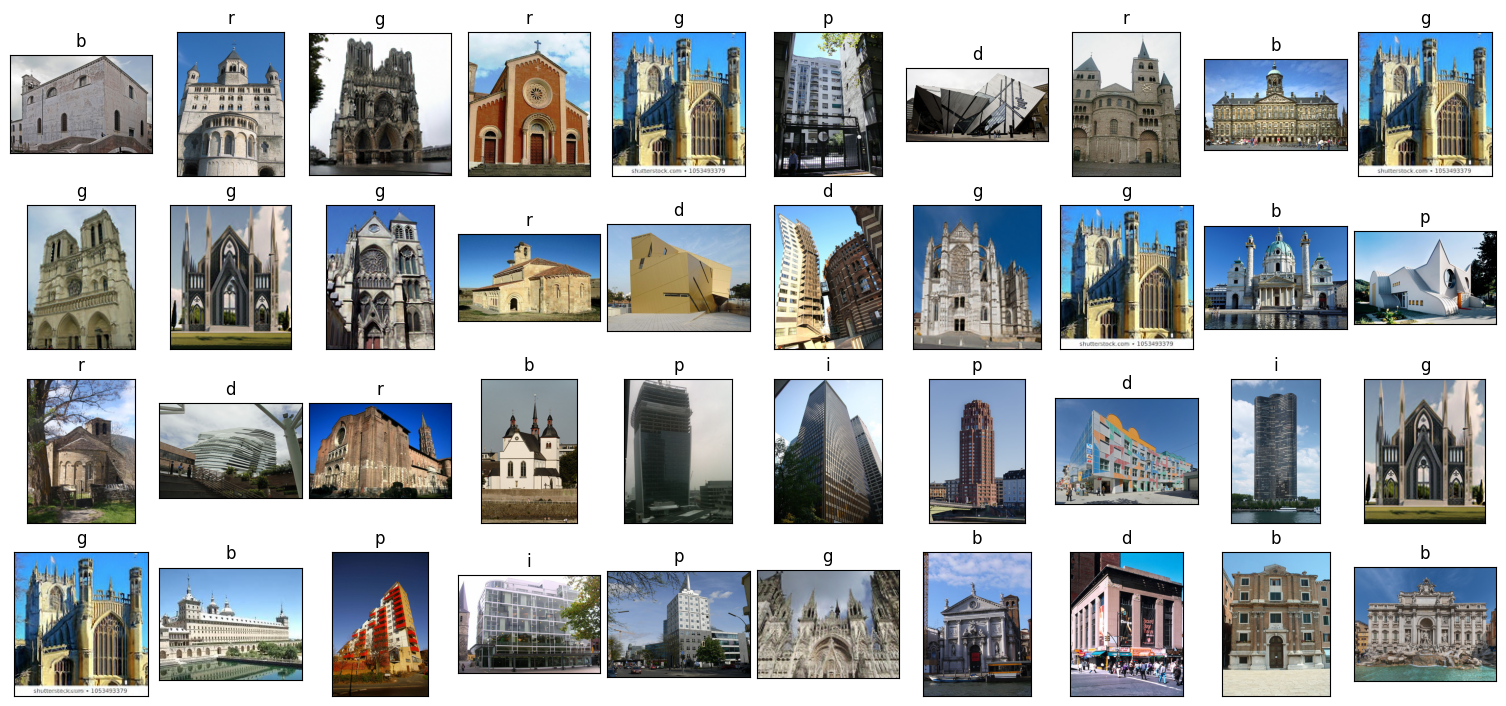

In [7]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

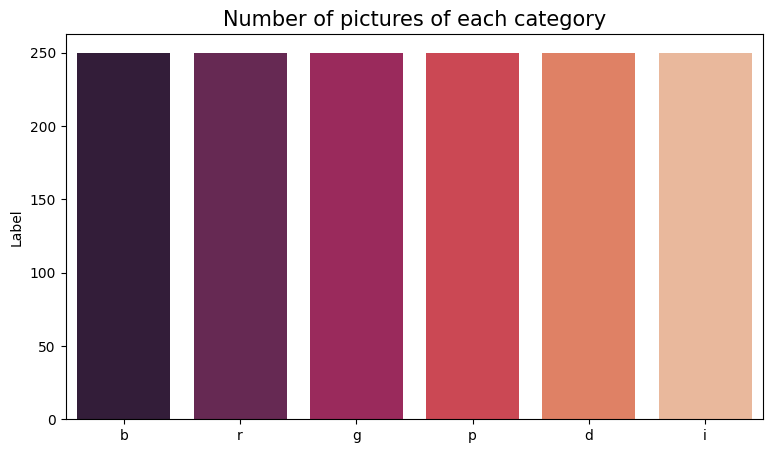

In [8]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [9]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [10]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')


Found 1200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [11]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [12]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
38/38 [==============================] - 236s 6s/step - loss: 1.9248 - accuracy: 0.2742 - val_loss: 2.0778 - val_accuracy: 0.1833
Epoch 2/10
38/38 [==============================] - 10s 260ms/step - loss: 1.1571 - accuracy: 0.5442 - val_loss: 2.0066 - val_accuracy: 0.2867
Epoch 3/10
38/38 [==============================] - 10s 260ms/step - loss: 0.7801 - accuracy: 0.7142 - val_loss: 2.3126 - val_accuracy: 0.2433
Epoch 4/10
38/38 [==============================] - 10s 259ms/step - loss: 0.4428 - accuracy: 0.8525 - val_loss: 3.0967 - val_accuracy: 0.2600
Epoch 5/10
38/38 [==============================] - 10s 262ms/step - loss: 0.2158 - accuracy: 0.9442 - val_loss: 2.8472 - val_accuracy: 0.2900
Epoch 6/10
38/38 [==============================] - 10s 258ms/step - loss: 0.1037 - accuracy: 0.9858 - val_loss: 3.1875 - val_accuracy: 0.2967
Epoch 7/10
38/38 [==============================] - 10s 261ms/step - loss: 0.0641 - accuracy: 0.9892 - val_loss: 3.6523 - val_accuracy: 0.2967
E

In [13]:
test_datagen =  ImageDataGenerator(rescale=1/255) 

test_gen  = test_datagen.flow_from_directory('/content/drive/MyDrive/architecture_small/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 300 images belonging to 6 classes.


In [14]:
cnn.evaluate(test_gen)


10/10 [==============================] - 58s 6s/step - loss: 5.4892 - accuracy: 0.2667


[5.489154815673828, 0.2666666805744171]

In [16]:
# Predict the label of the test_images
pred = cnn.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')


10/10 [==============================] - 3s 314ms/step
Accuracy on the test set: 16.67%


In [17]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.11      0.04      0.06        50
           d       0.18      0.16      0.17        50
           g       1.00      0.00      0.00        50
           i       0.15      0.16      0.16        50
           p       0.13      0.14      0.14        50
           r       0.19      0.50      0.28        50

    accuracy                           0.17       300
   macro avg       0.29      0.17      0.13       300
weighted avg       0.29      0.17      0.13       300



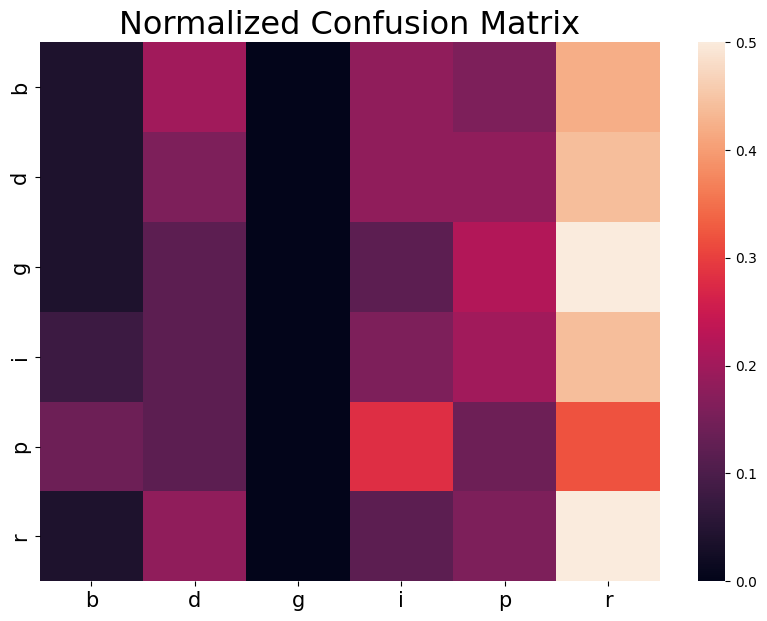

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [19]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.20
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [20]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(150, 150, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=4,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


29084464/29084464 [==============================] - 0s 0us/step


DenseNet121          trained in 51.99 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 46.71 sec
74836368/74836368 [==============================] - 0s 0us/step
DenseNet201          trained in 57.05 sec
16705208/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 51.68 sec
27018416/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 54.77 sec
87910968/87910968 [==============================] - 1s 0us/step


InceptionV3          trained in 50.16 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 48.56 sec
234545216/234545216 [==============================] - 1s 0us/step
ResNet152V2          trained in 55.0 sec
94765736/94765736 [==============================] - 1s 0us/step
ResNet50             trained in 47.69 sec
94668760/94668760 [==============================] - 0s 0us/step
ResNet50V2           trained in 48.3 sec
80134624/80134624 [==============================] - 0s 0us/step
VGG19                trained in 46.13 sec
58889256/58889256 [==============================] - 0s 0us/step
VGG16                trained in 44.12 sec
83683744/83683744 [==============================] - 1s 0us/step
Xception             trained in 46.93 sec


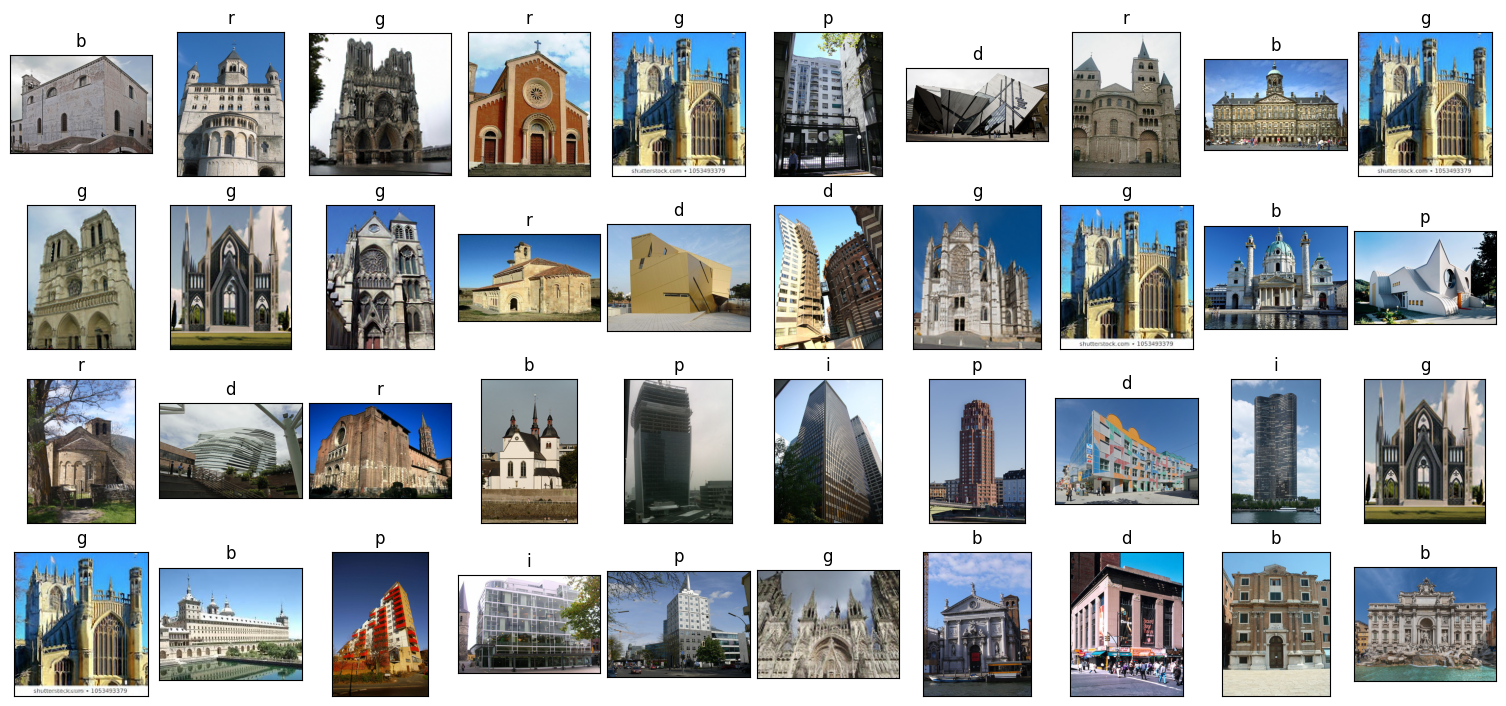

In [22]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [23]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

10/10 [==============================] - 5s 343ms/step
**DenseNet121 has a 66.00% accuracy on the test set**
10/10 [==============================] - 4s 339ms/step
**MobileNetV2 has a 64.67% accuracy on the test set**
10/10 [==============================] - 7s 341ms/step
**DenseNet201 has a 66.33% accuracy on the test set**
10/10 [==============================] - 5s 329ms/step
**EfficientNetB0 has a 21.33% accuracy on the test set**
10/10 [==============================] - 5s 337ms/step
**EfficientNetB1 has a 18.67% accuracy on the test set**
10/10 [==============================] - 5s 333ms/step
**InceptionV3 has a 65.33% accuracy on the test set**
10/10 [==============================] - 4s 337ms/step
**MobileNetV3Large has a 29.00% accuracy on the test set**
10/10 [==============================] - 7s 335ms/step
**ResNet152V2 has a 70.00% accuracy on the test set**
10/10 [==============================] - 4s 331ms/step
**ResNet50 has a 33.00% accuracy on the test set**
10/10 [====

model  val_accuracy  accuracy  Training time (sec)
0        ResNet152V2        0.8300    0.7000                55.00
1         ResNet50V2        0.8000    0.6867                48.30
2        DenseNet201        0.7933    0.6633                57.05
3        DenseNet121        0.8133    0.6600                51.99
4        InceptionV3        0.7933    0.6533                50.16
5        MobileNetV2        0.7833    0.6467                46.71
6           Xception        0.7800    0.6233                46.93
7              VGG19        0.7733    0.6200                46.13
8              VGG16        0.7367    0.5967                44.12
9           ResNet50        0.5300    0.3300                47.69
10  MobileNetV3Large        0.4933    0.2900                48.56
11    EfficientNetB0        0.1733    0.2133                51.68
12    EfficientNetB1        0.1600    0.1867                54.77

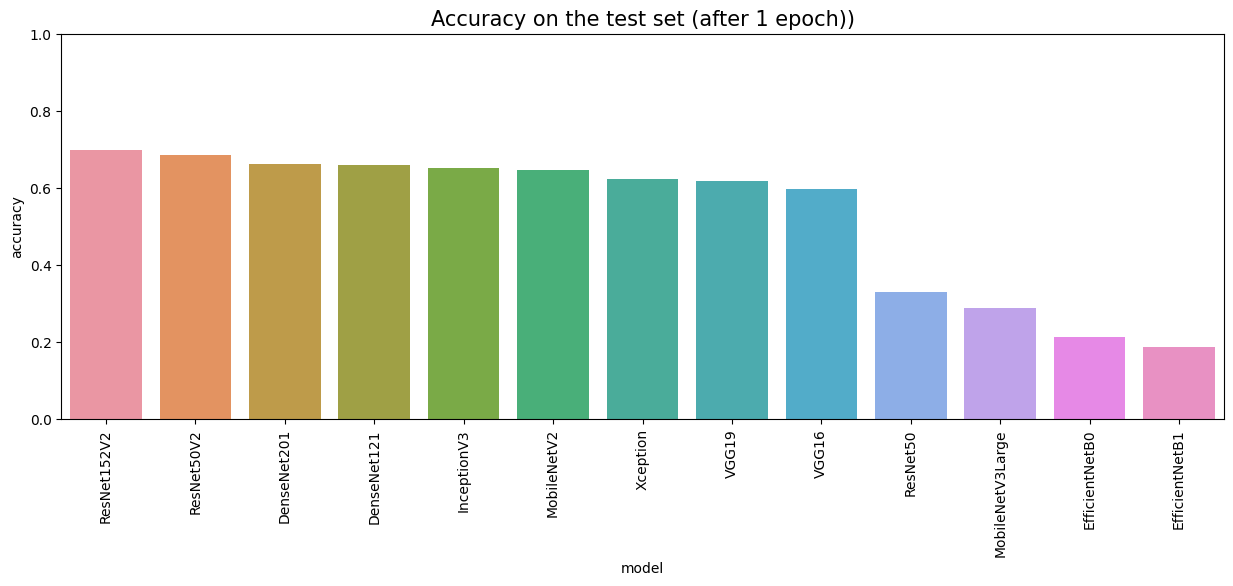

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [25]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 25s 373ms/step - loss: 0.2945 - accuracy: 0.6050 - val_loss: 0.1991 - val_accuracy: 0.7400
Epoch 2/4
38/38 [==============================] - 11s 282ms/step - loss: 0.1592 - accuracy: 0.8025 - val_loss: 0.1717 - val_accuracy: 0.7867
Epoch 3/4
38/38 [==============================] - 11s 285ms/step - loss: 0.1190 - accuracy: 0.8558 - val_loss: 0.1516 - val_accuracy: 0.8167
Epoch 4/4
38/38 [==============================] - 11s 286ms/step - loss: 0.0964 - accuracy: 0.8825 - val_loss: 0.1444 - val_accuracy: 0.8100


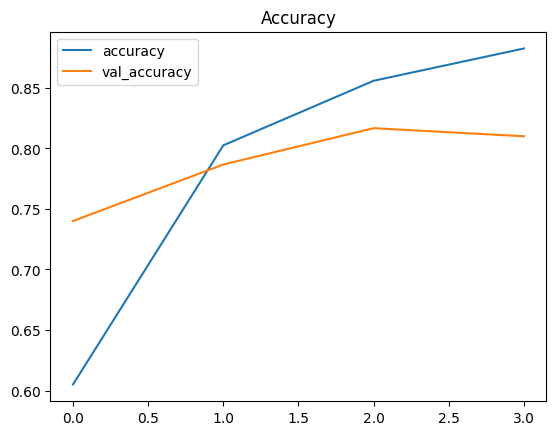

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

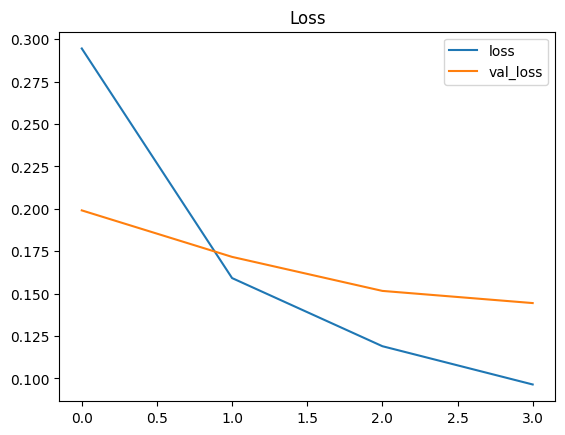

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 335ms/step
Accuracy on the test set: 67.00%


In [29]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.79      1.00      0.88        50
           d       0.78      0.70      0.74        50
           g       0.71      0.10      0.18        50
           i       0.73      0.70      0.71        50
           p       0.61      0.60      0.61        50
           r       0.52      0.92      0.67        50

    accuracy                           0.67       300
   macro avg       0.69      0.67      0.63       300
weighted avg       0.69      0.67      0.63       300



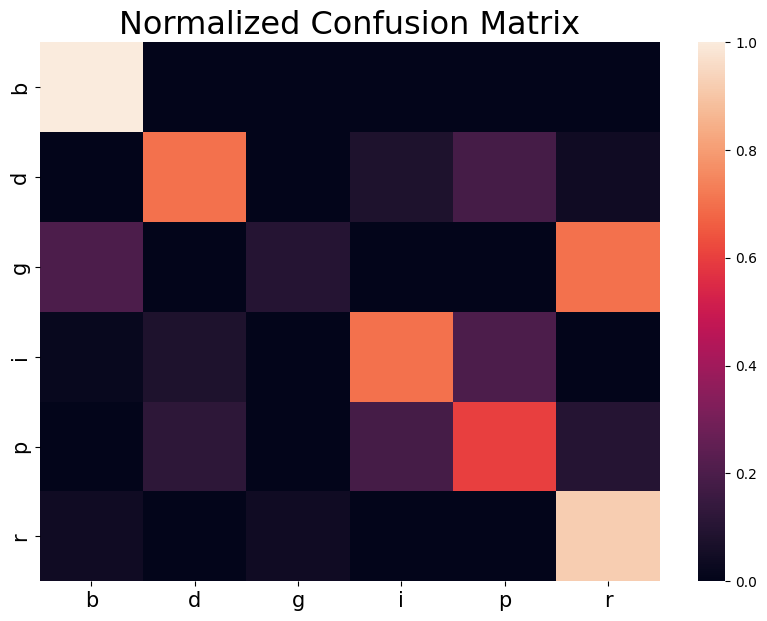

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 15s 307ms/step - loss: 0.2665 - accuracy: 0.6242 - val_loss: 0.1795 - val_accuracy: 0.7867
Epoch 2/4
38/38 [==============================] - 11s 293ms/step - loss: 0.1308 - accuracy: 0.8450 - val_loss: 0.1670 - val_accuracy: 0.8000
Epoch 3/4
38/38 [==============================] - 11s 282ms/step - loss: 0.0935 - accuracy: 0.9000 - val_loss: 0.1706 - val_accuracy: 0.7867
Epoch 4/4
38/38 [==============================] - 11s 280ms/step - loss: 0.0614 - accuracy: 0.9433 - val_loss: 0.1944 - val_accuracy: 0.7967


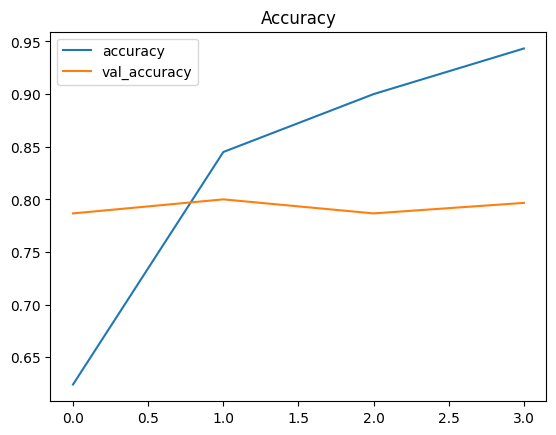

In [32]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

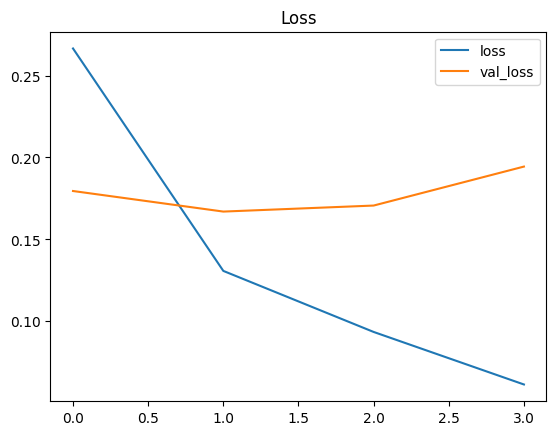

In [33]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [34]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 332ms/step
Accuracy on the test set: 65.67%


In [35]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.81      0.92      0.86        50
           d       0.72      0.84      0.78        50
           g       1.00      0.06      0.11        50
           i       0.68      0.76      0.72        50
           p       0.62      0.40      0.49        50
           r       0.51      0.96      0.67        50

    accuracy                           0.66       300
   macro avg       0.72      0.66      0.60       300
weighted avg       0.72      0.66      0.60       300



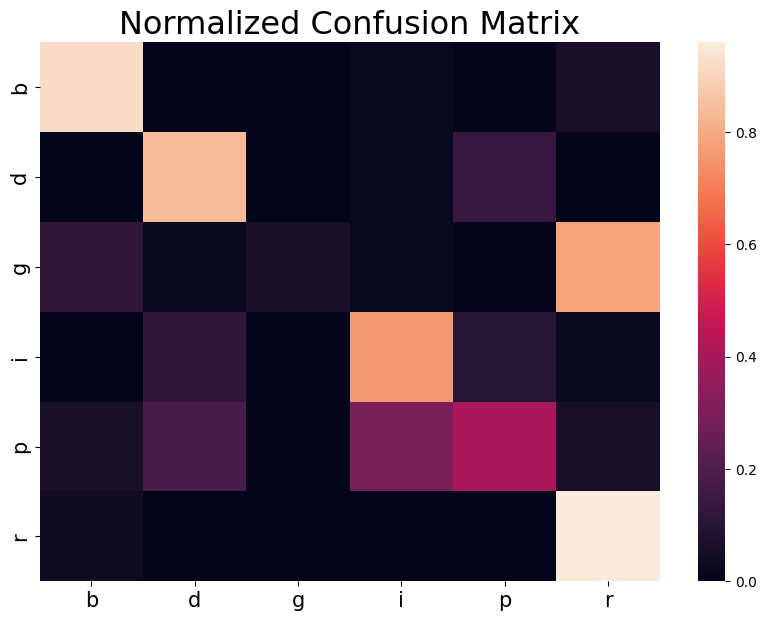

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [37]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 15s 304ms/step - loss: 0.3295 - accuracy: 0.5692 - val_loss: 0.2134 - val_accuracy: 0.7333
Epoch 2/4
38/38 [==============================] - 11s 281ms/step - loss: 0.1805 - accuracy: 0.7775 - val_loss: 0.1637 - val_accuracy: 0.7900
Epoch 3/4
38/38 [==============================] - 11s 280ms/step - loss: 0.1423 - accuracy: 0.8375 - val_loss: 0.1628 - val_accuracy: 0.7733
Epoch 4/4
38/38 [==============================] - 11s 281ms/step - loss: 0.1252 - accuracy: 0.8567 - val_loss: 0.1487 - val_accuracy: 0.8100


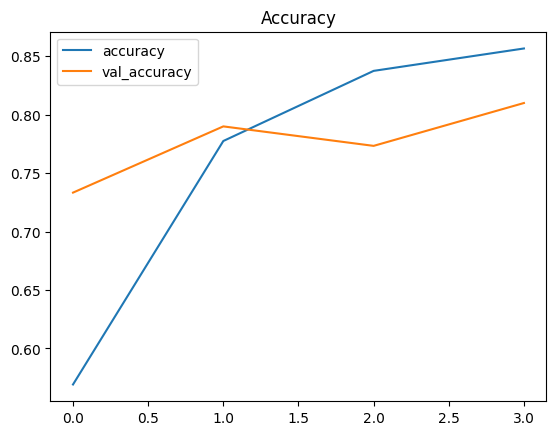

In [38]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

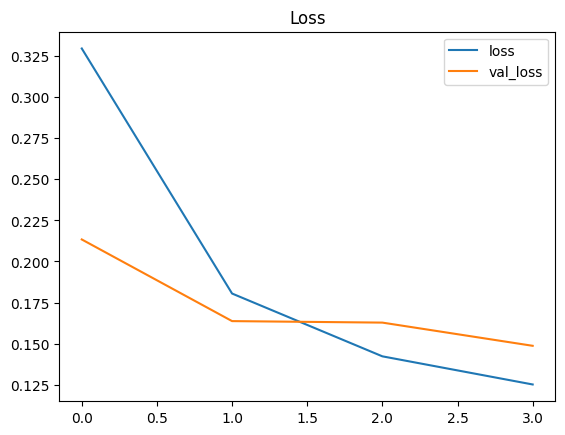

In [39]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 337ms/step
Accuracy on the test set: 60.33%


In [41]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.69      0.98      0.81        50
           d       0.58      0.82      0.68        50
           g       0.67      0.04      0.08        50
           i       0.70      0.62      0.66        50
           p       0.47      0.30      0.37        50
           r       0.54      0.86      0.67        50

    accuracy                           0.60       300
   macro avg       0.61      0.60      0.54       300
weighted avg       0.61      0.60      0.54       300



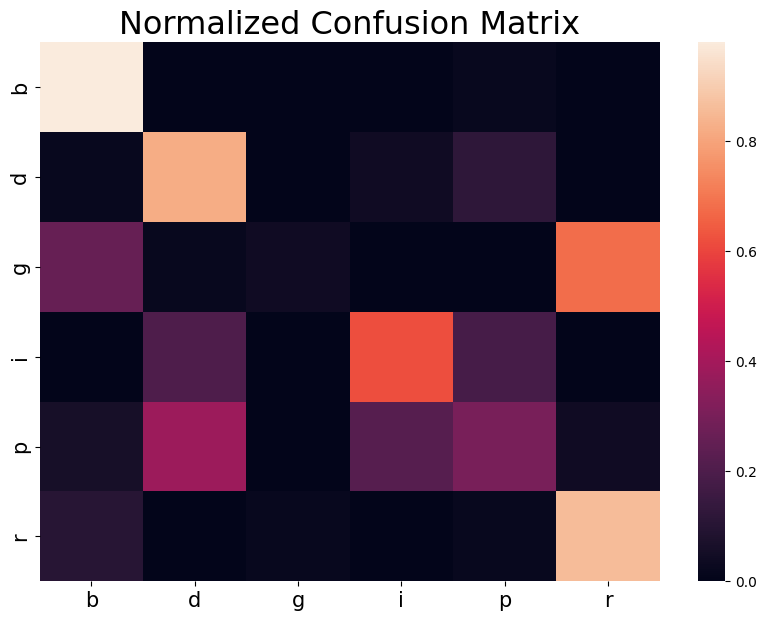

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [43]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=4)


Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 25s 368ms/step - loss: 0.3126 - accuracy: 0.5908 - val_loss: 0.1961 - val_accuracy: 0.7767
Epoch 2/4
38/38 [==============================] - 11s 283ms/step - loss: 0.1633 - accuracy: 0.8000 - val_loss: 0.1628 - val_accuracy: 0.7800
Epoch 3/4
38/38 [==============================] - 11s 282ms/step - loss: 0.1347 - accuracy: 0.8383 - val_loss: 0.1821 - val_accuracy: 0.7733
Epoch 4/4
38/38 [==============================] - 11s 281ms/step - loss: 0.1036 - accuracy: 0.8825 - val_loss: 0.1426 - val_accuracy: 0.8233


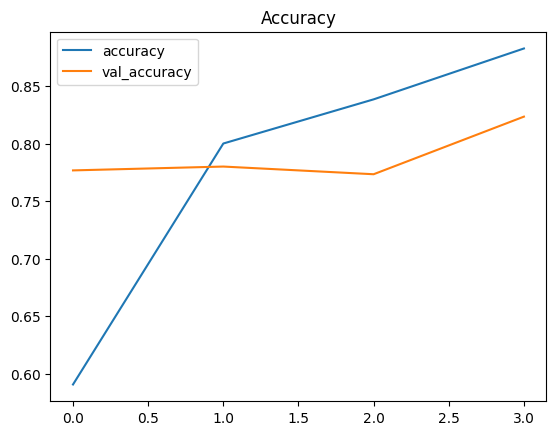

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

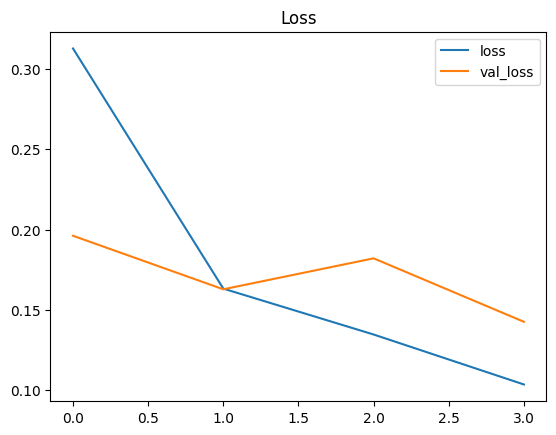

In [45]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [46]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 337ms/step
Accuracy on the test set: 67.33%


In [47]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.79      1.00      0.88        50
           d       0.75      0.78      0.76        50
           g       0.83      0.10      0.18        50
           i       0.80      0.56      0.66        50
           p       0.57      0.64      0.60        50
           r       0.55      0.96      0.70        50

    accuracy                           0.67       300
   macro avg       0.72      0.67      0.63       300
weighted avg       0.72      0.67      0.63       300



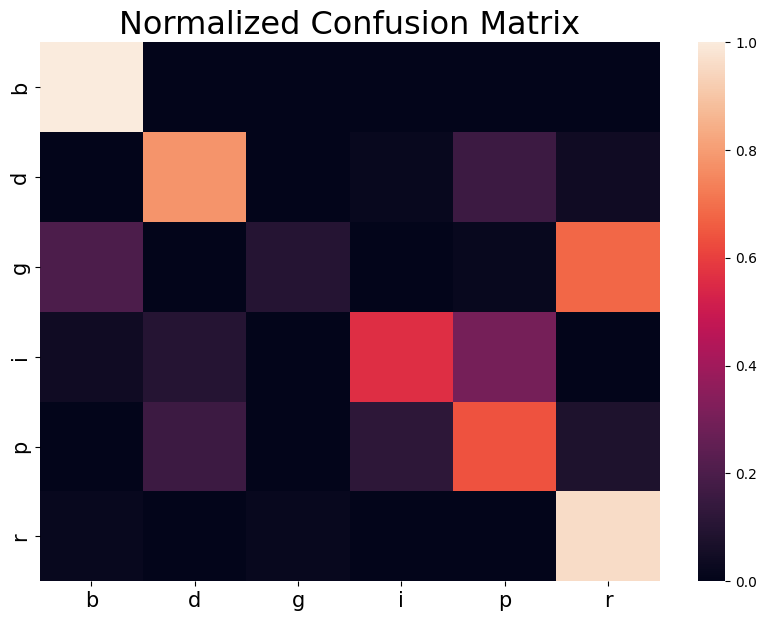

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [49]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.VGG16)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 13s 291ms/step - loss: 0.4395 - accuracy: 0.4117 - val_loss: 0.3753 - val_accuracy: 0.5300
Epoch 2/4
38/38 [==============================] - 11s 282ms/step - loss: 0.3124 - accuracy: 0.6500 - val_loss: 0.2659 - val_accuracy: 0.7600
Epoch 3/4
38/38 [==============================] - 11s 279ms/step - loss: 0.2346 - accuracy: 0.7242 - val_loss: 0.2209 - val_accuracy: 0.7567
Epoch 4/4
38/38 [==============================] - 11s 281ms/step - loss: 0.1982 - accuracy: 0.7750 - val_loss: 0.2007 - val_accuracy: 0.7700


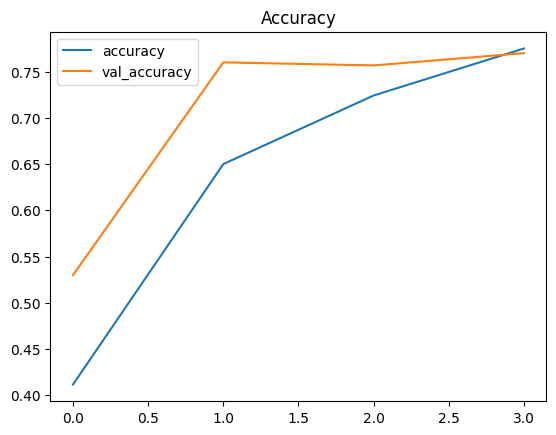

In [50]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

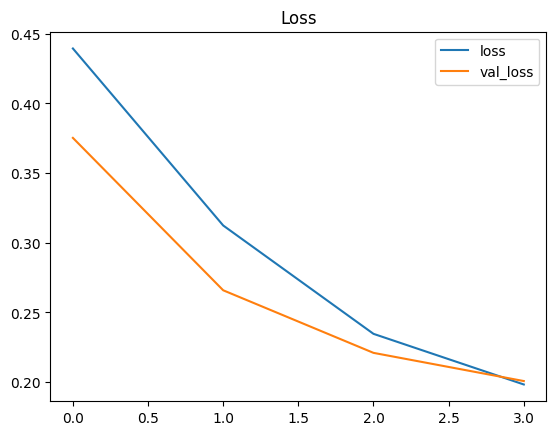

In [51]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [52]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 3s 328ms/step
Accuracy on the test set: 61.67%


In [53]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.68      1.00      0.81        50
           d       0.54      0.76      0.63        50
           g       0.67      0.28      0.39        50
           i       0.74      0.34      0.47        50
           p       0.56      0.58      0.57        50
           r       0.63      0.74      0.68        50

    accuracy                           0.62       300
   macro avg       0.63      0.62      0.59       300
weighted avg       0.63      0.62      0.59       300



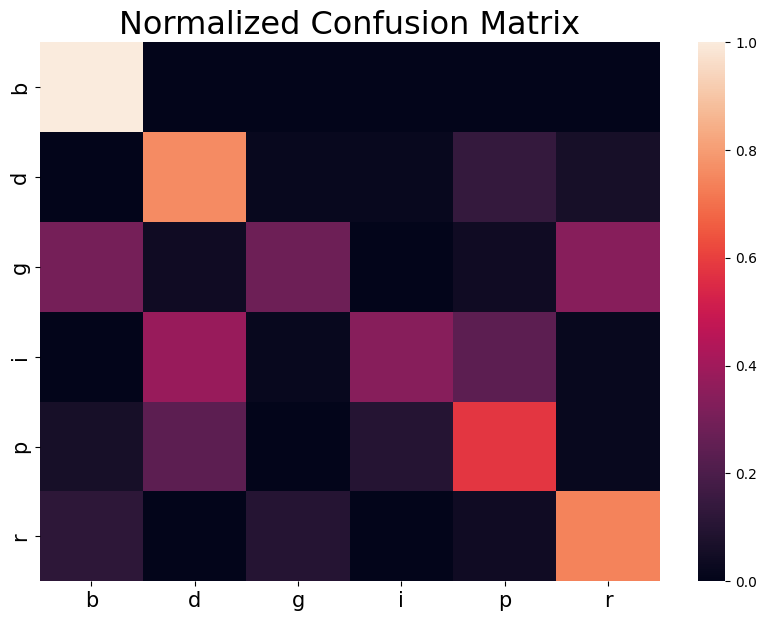

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [55]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV3Large)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


Epoch 1/4
38/38 [==============================] - 16s 308ms/step - loss: 0.4735 - accuracy: 0.2375 - val_loss: 0.4279 - val_accuracy: 0.2367
Epoch 2/4
38/38 [==============================] - 11s 279ms/step - loss: 0.4138 - accuracy: 0.3642 - val_loss: 0.4003 - val_accuracy: 0.4033
Epoch 3/4
38/38 [==============================] - 11s 278ms/step - loss: 0.3816 - accuracy: 0.4525 - val_loss: 0.3688 - val_accuracy: 0.4833
Epoch 4/4
38/38 [==============================] - 11s 277ms/step - loss: 0.3500 - accuracy: 0.5050 - val_loss: 0.3581 - val_accuracy: 0.4400


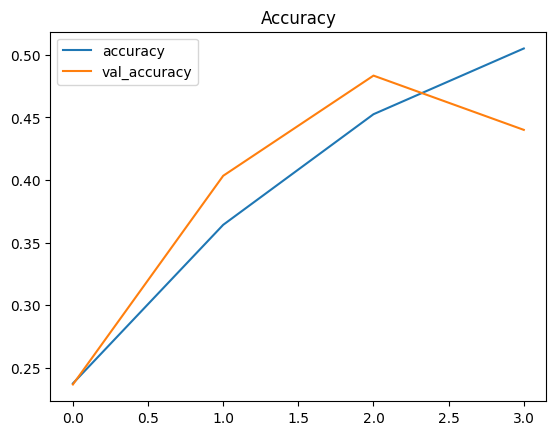

In [56]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

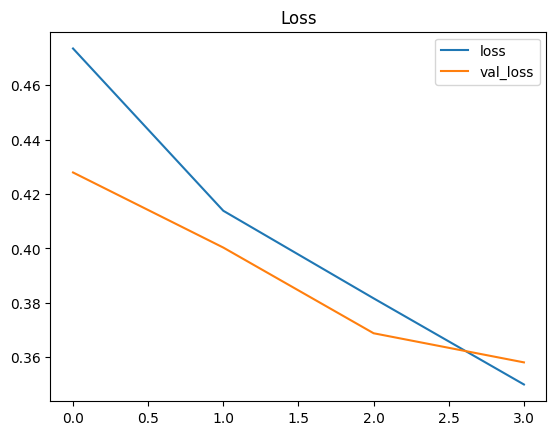

In [57]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [58]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 329ms/step


# Accuracy on the test set: 28.67%

In [59]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.33      0.32      0.32        50
           d       0.34      0.46      0.39        50
           g       0.25      0.34      0.29        50
           i       0.29      0.52      0.37        50
           p       0.25      0.02      0.04        50
           r       0.14      0.06      0.08        50

    accuracy                           0.29       300
   macro avg       0.27      0.29      0.25       300
weighted avg       0.27      0.29      0.25       300



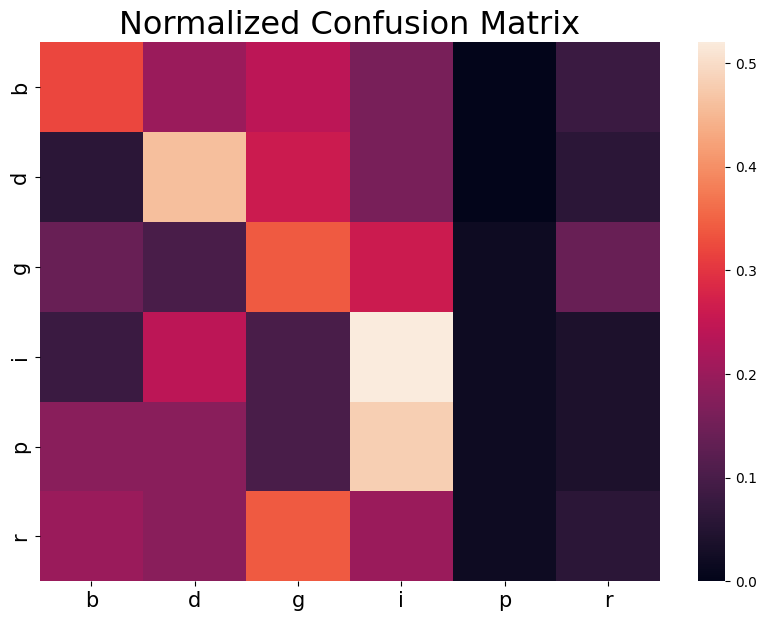

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()